# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [19]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

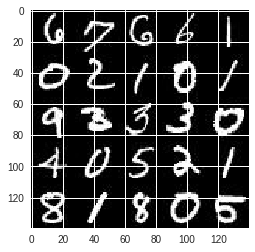

In [20]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

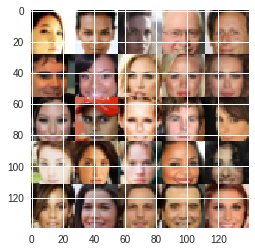

In [21]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [23]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="z_dim")
    lr = tf.placeholder(tf.float32)
    
    return input_real, input_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [24]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        alpha = 0.2
        k_size = 3
        
        x1 = tf.layers.conv2d(images, 32, k_size, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 64, k_size, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x64
        relu2 = tf.layers.dropout(relu2, rate=0.3)
        
        x3 = tf.layers.conv2d(relu2, 128, k_size, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x128
        relu3 = tf.layers.dropout(relu3, rate=0.3)

        #average pooling
        features = tf.reduce_mean(relu3, (1, 2)) 
        # 256
        features = tf.layers.dropout(features, rate=0.1)

        logits = tf.layers.dense(features, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [0]:
import numpy as np
# add gaussian noise to each generator layer
def gaussian_noise_layer(input_layer, std):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_layer + noise

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = False if is_train else True
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        alpha = 0.2
        k_size = 3
        drop_rate = 0.3
        last_drop_rate = 0.1
        #std = 0.005
        
        x1 = tf.layers.dense(z, 7 * 7 * 512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = gaussian_noise_layer(x1, std)
        x1 = tf.layers.dropout(x1, rate=drop_rate)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, k_size, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = gaussian_noise_layer(x2, std)
        x2 = tf.layers.dropout(x2, rate=drop_rate)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, k_size, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #x3 = gaussian_noise_layer(x3, std)
        x3 = tf.layers.dropout(x3, rate=drop_rate)
        # 7x7x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, k_size, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #x4 = gaussian_noise_layer(x4, std)
        x4 = tf.layers.dropout(x4, rate=last_drop_rate)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, k_size, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # smooth = 0.1
    smooth = np.random.uniform(0.75, 0.9)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    from scipy.stats import truncnorm

    # TODO: Build Model
    # image_channels = 1 if data_image_mode == "L" else 3

    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    #todo change batch_z to tensor
    steps = 0
    print_every = 50
    show_every = 250
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1

                # use truncated normal distribution to generate random pixels
                batch_z = truncnorm.rvs(a=-1, b=1, loc=0, scale=0.5, size=(batch_size, z_dim))
                # Run optimizers

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "iteration: {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/5... iteration: 50... Discriminator Loss: 1.3042... Generator Loss: 0.6251
Epoch 1/5... iteration: 100... Discriminator Loss: 1.3357... Generator Loss: 0.8466
Epoch 1/5... iteration: 150... Discriminator Loss: 1.3455... Generator Loss: 0.8256
Epoch 1/5... iteration: 200... Discriminator Loss: 1.3459... Generator Loss: 0.8308
Epoch 1/5... iteration: 250... Discriminator Loss: 1.3510... Generator Loss: 0.8377


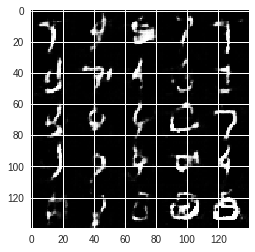

Epoch 1/5... iteration: 300... Discriminator Loss: 1.3561... Generator Loss: 0.8458
Epoch 1/5... iteration: 350... Discriminator Loss: 1.3431... Generator Loss: 0.8452
Epoch 1/5... iteration: 400... Discriminator Loss: 1.3505... Generator Loss: 0.8430
Epoch 1/5... iteration: 450... Discriminator Loss: 1.3517... Generator Loss: 0.8252
Epoch 2/5... iteration: 500... Discriminator Loss: 1.3567... Generator Loss: 0.8311


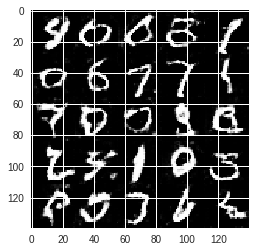

Epoch 2/5... iteration: 550... Discriminator Loss: 1.3499... Generator Loss: 0.8399
Epoch 2/5... iteration: 600... Discriminator Loss: 1.3481... Generator Loss: 0.8378
Epoch 2/5... iteration: 650... Discriminator Loss: 1.3492... Generator Loss: 0.8534
Epoch 2/5... iteration: 700... Discriminator Loss: 1.3498... Generator Loss: 0.8429
Epoch 2/5... iteration: 750... Discriminator Loss: 1.3474... Generator Loss: 0.8318


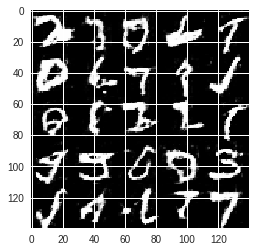

Epoch 2/5... iteration: 800... Discriminator Loss: 1.3508... Generator Loss: 0.8241
Epoch 2/5... iteration: 850... Discriminator Loss: 1.3461... Generator Loss: 0.8352
Epoch 2/5... iteration: 900... Discriminator Loss: 1.3370... Generator Loss: 0.8578
Epoch 3/5... iteration: 950... Discriminator Loss: 1.3369... Generator Loss: 0.8599
Epoch 3/5... iteration: 1000... Discriminator Loss: 1.3393... Generator Loss: 0.8299


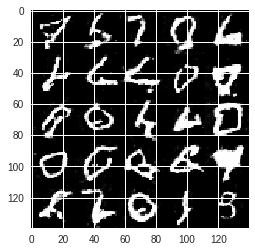

Epoch 3/5... iteration: 1050... Discriminator Loss: 1.3366... Generator Loss: 0.8278
Epoch 3/5... iteration: 1100... Discriminator Loss: 1.3463... Generator Loss: 0.8397
Epoch 3/5... iteration: 1150... Discriminator Loss: 1.3409... Generator Loss: 0.8309
Epoch 3/5... iteration: 1200... Discriminator Loss: 1.3357... Generator Loss: 0.8351
Epoch 3/5... iteration: 1250... Discriminator Loss: 1.3263... Generator Loss: 0.8686


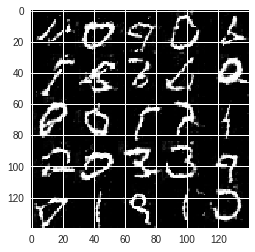

Epoch 3/5... iteration: 1300... Discriminator Loss: 1.3310... Generator Loss: 0.8322
Epoch 3/5... iteration: 1350... Discriminator Loss: 1.3293... Generator Loss: 0.8364
Epoch 3/5... iteration: 1400... Discriminator Loss: 1.3150... Generator Loss: 0.8699
Epoch 4/5... iteration: 1450... Discriminator Loss: 1.3304... Generator Loss: 0.8569
Epoch 4/5... iteration: 1500... Discriminator Loss: 1.3249... Generator Loss: 0.8656


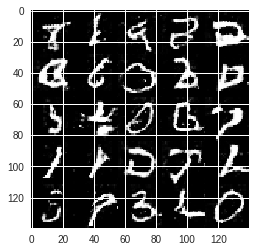

Epoch 4/5... iteration: 1550... Discriminator Loss: 1.3372... Generator Loss: 0.8259
Epoch 4/5... iteration: 1600... Discriminator Loss: 1.3116... Generator Loss: 0.8589
Epoch 4/5... iteration: 1650... Discriminator Loss: 1.3210... Generator Loss: 0.8476
Epoch 4/5... iteration: 1700... Discriminator Loss: 1.3181... Generator Loss: 0.8367
Epoch 4/5... iteration: 1750... Discriminator Loss: 1.3059... Generator Loss: 0.8653


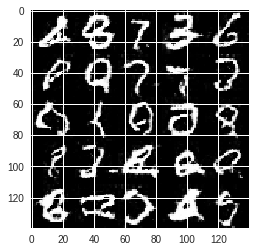

Epoch 4/5... iteration: 1800... Discriminator Loss: 1.3016... Generator Loss: 0.8902
Epoch 4/5... iteration: 1850... Discriminator Loss: 1.3013... Generator Loss: 0.9072
Epoch 5/5... iteration: 1900... Discriminator Loss: 1.3041... Generator Loss: 0.8668
Epoch 5/5... iteration: 1950... Discriminator Loss: 1.3073... Generator Loss: 0.8274
Epoch 5/5... iteration: 2000... Discriminator Loss: 1.2874... Generator Loss: 0.8690


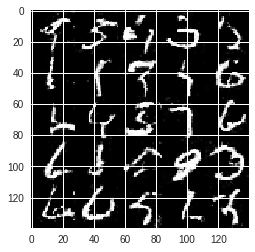

Epoch 5/5... iteration: 2050... Discriminator Loss: 1.2850... Generator Loss: 0.8502
Epoch 5/5... iteration: 2100... Discriminator Loss: 1.2902... Generator Loss: 0.8773
Epoch 5/5... iteration: 2150... Discriminator Loss: 1.3053... Generator Loss: 0.8892
Epoch 5/5... iteration: 2200... Discriminator Loss: 1.2885... Generator Loss: 0.8981
Epoch 5/5... iteration: 2250... Discriminator Loss: 1.2742... Generator Loss: 0.8871


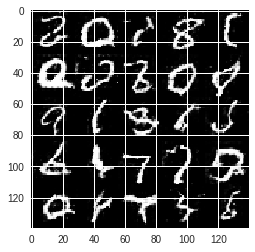

Epoch 5/5... iteration: 2300... Discriminator Loss: 1.2765... Generator Loss: 0.8775


In [31]:
batch_size = 128
z_dim = 120
learning_rate = 0.0005
beta1 = 0.55

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/20... iteration: 50... Discriminator Loss: 1.3202... Generator Loss: 0.9625
Epoch 1/20... iteration: 100... Discriminator Loss: 1.3016... Generator Loss: 1.0136
Epoch 1/20... iteration: 150... Discriminator Loss: 1.3097... Generator Loss: 0.9741
Epoch 1/20... iteration: 200... Discriminator Loss: 1.3117... Generator Loss: 0.9886
Epoch 1/20... iteration: 250... Discriminator Loss: 1.3194... Generator Loss: 0.9830


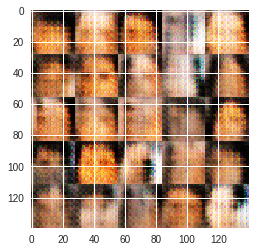

Epoch 1/20... iteration: 300... Discriminator Loss: 1.3335... Generator Loss: 0.9552
Epoch 1/20... iteration: 350... Discriminator Loss: 1.3192... Generator Loss: 0.9772
Epoch 1/20... iteration: 400... Discriminator Loss: 1.3236... Generator Loss: 0.9837
Epoch 1/20... iteration: 450... Discriminator Loss: 1.3267... Generator Loss: 0.9744
Epoch 1/20... iteration: 500... Discriminator Loss: 1.3229... Generator Loss: 0.9870


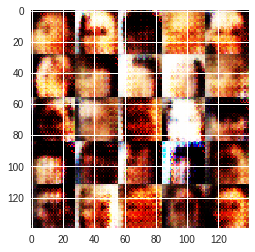

Epoch 1/20... iteration: 550... Discriminator Loss: 1.3337... Generator Loss: 0.9617
Epoch 1/20... iteration: 600... Discriminator Loss: 1.3124... Generator Loss: 0.9794
Epoch 1/20... iteration: 650... Discriminator Loss: 1.3014... Generator Loss: 0.9938
Epoch 1/20... iteration: 700... Discriminator Loss: 1.3155... Generator Loss: 1.0064
Epoch 1/20... iteration: 750... Discriminator Loss: 1.2572... Generator Loss: 1.0552


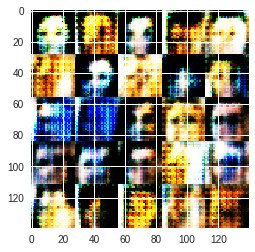

Epoch 1/20... iteration: 800... Discriminator Loss: 1.2859... Generator Loss: 1.0247
Epoch 1/20... iteration: 850... Discriminator Loss: 1.3155... Generator Loss: 1.0073
Epoch 1/20... iteration: 900... Discriminator Loss: 1.3164... Generator Loss: 0.9981
Epoch 1/20... iteration: 950... Discriminator Loss: 1.3391... Generator Loss: 0.9943
Epoch 1/20... iteration: 1000... Discriminator Loss: 1.3166... Generator Loss: 1.0018


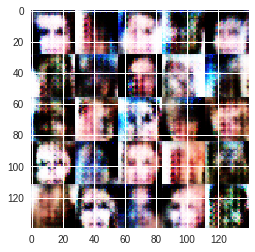

Epoch 1/20... iteration: 1050... Discriminator Loss: 1.3140... Generator Loss: 0.9546
Epoch 1/20... iteration: 1100... Discriminator Loss: 1.2807... Generator Loss: 1.0378
Epoch 1/20... iteration: 1150... Discriminator Loss: 1.3177... Generator Loss: 0.9625
Epoch 1/20... iteration: 1200... Discriminator Loss: 1.3040... Generator Loss: 0.9916
Epoch 1/20... iteration: 1250... Discriminator Loss: 1.3365... Generator Loss: 0.9675


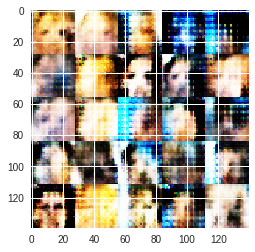

Epoch 1/20... iteration: 1300... Discriminator Loss: 1.2878... Generator Loss: 0.9835
Epoch 1/20... iteration: 1350... Discriminator Loss: 1.3217... Generator Loss: 0.9692
Epoch 1/20... iteration: 1400... Discriminator Loss: 1.3492... Generator Loss: 0.9381
Epoch 1/20... iteration: 1450... Discriminator Loss: 1.2881... Generator Loss: 0.9862
Epoch 1/20... iteration: 1500... Discriminator Loss: 1.3365... Generator Loss: 0.9778


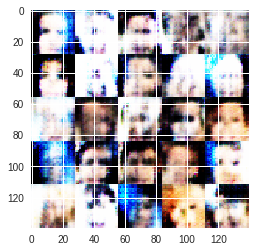

Epoch 1/20... iteration: 1550... Discriminator Loss: 1.3274... Generator Loss: 0.9600
Epoch 2/20... iteration: 1600... Discriminator Loss: 1.3398... Generator Loss: 0.9882
Epoch 2/20... iteration: 1650... Discriminator Loss: 1.3244... Generator Loss: 0.9524
Epoch 2/20... iteration: 1700... Discriminator Loss: 1.2967... Generator Loss: 1.0084
Epoch 2/20... iteration: 1750... Discriminator Loss: 1.3235... Generator Loss: 0.9847


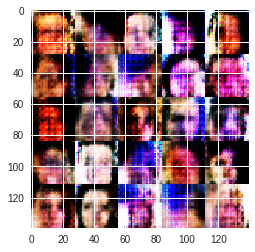

Epoch 2/20... iteration: 1800... Discriminator Loss: 1.3188... Generator Loss: 0.9769
Epoch 2/20... iteration: 1850... Discriminator Loss: 1.3302... Generator Loss: 0.9726
Epoch 2/20... iteration: 1900... Discriminator Loss: 1.3281... Generator Loss: 0.9705
Epoch 2/20... iteration: 1950... Discriminator Loss: 1.3231... Generator Loss: 0.9870
Epoch 2/20... iteration: 2000... Discriminator Loss: 1.3037... Generator Loss: 1.0162


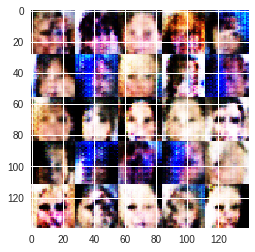

Epoch 2/20... iteration: 2050... Discriminator Loss: 1.3502... Generator Loss: 0.9374
Epoch 2/20... iteration: 2100... Discriminator Loss: 1.3125... Generator Loss: 0.9813
Epoch 2/20... iteration: 2150... Discriminator Loss: 1.3582... Generator Loss: 0.9321
Epoch 2/20... iteration: 2200... Discriminator Loss: 1.3180... Generator Loss: 0.9768
Epoch 2/20... iteration: 2250... Discriminator Loss: 1.3086... Generator Loss: 0.9906


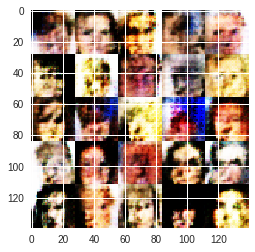

Epoch 2/20... iteration: 2300... Discriminator Loss: 1.3234... Generator Loss: 0.9781
Epoch 2/20... iteration: 2350... Discriminator Loss: 1.3255... Generator Loss: 0.9841
Epoch 2/20... iteration: 2400... Discriminator Loss: 1.3166... Generator Loss: 0.9676
Epoch 2/20... iteration: 2450... Discriminator Loss: 1.3319... Generator Loss: 0.9712
Epoch 2/20... iteration: 2500... Discriminator Loss: 1.3331... Generator Loss: 0.9848


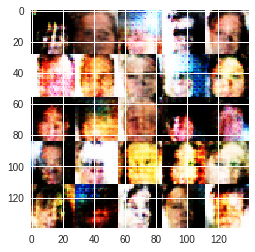

Epoch 2/20... iteration: 2550... Discriminator Loss: 1.3111... Generator Loss: 0.9755
Epoch 2/20... iteration: 2600... Discriminator Loss: 1.3329... Generator Loss: 0.9644
Epoch 2/20... iteration: 2650... Discriminator Loss: 1.3312... Generator Loss: 0.9605
Epoch 2/20... iteration: 2700... Discriminator Loss: 1.3320... Generator Loss: 0.9894
Epoch 2/20... iteration: 2750... Discriminator Loss: 1.3169... Generator Loss: 0.9889


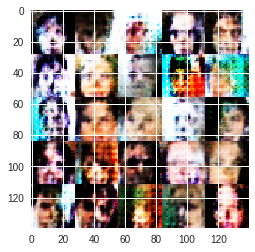

Epoch 2/20... iteration: 2800... Discriminator Loss: 1.3287... Generator Loss: 0.9620
Epoch 2/20... iteration: 2850... Discriminator Loss: 1.3333... Generator Loss: 0.9608
Epoch 2/20... iteration: 2900... Discriminator Loss: 1.3216... Generator Loss: 0.9854
Epoch 2/20... iteration: 2950... Discriminator Loss: 1.3209... Generator Loss: 0.9769
Epoch 2/20... iteration: 3000... Discriminator Loss: 1.3153... Generator Loss: 0.9918


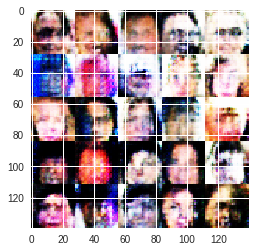

Epoch 2/20... iteration: 3050... Discriminator Loss: 1.2933... Generator Loss: 0.9946
Epoch 2/20... iteration: 3100... Discriminator Loss: 1.3129... Generator Loss: 0.9673
Epoch 2/20... iteration: 3150... Discriminator Loss: 1.3064... Generator Loss: 0.9746
Epoch 3/20... iteration: 3200... Discriminator Loss: 1.3415... Generator Loss: 0.9717
Epoch 3/20... iteration: 3250... Discriminator Loss: 1.3355... Generator Loss: 0.9691


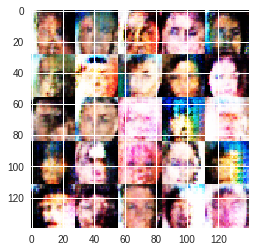

Epoch 3/20... iteration: 3300... Discriminator Loss: 1.3204... Generator Loss: 0.9751
Epoch 3/20... iteration: 3350... Discriminator Loss: 1.3109... Generator Loss: 0.9807
Epoch 3/20... iteration: 3400... Discriminator Loss: 1.3340... Generator Loss: 0.9790
Epoch 3/20... iteration: 3450... Discriminator Loss: 1.3296... Generator Loss: 0.9709
Epoch 3/20... iteration: 3500... Discriminator Loss: 1.3167... Generator Loss: 0.9671


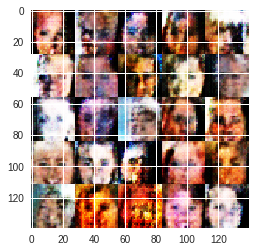

Epoch 3/20... iteration: 3550... Discriminator Loss: 1.3267... Generator Loss: 0.9764
Epoch 3/20... iteration: 3600... Discriminator Loss: 1.3321... Generator Loss: 0.9857
Epoch 3/20... iteration: 3650... Discriminator Loss: 1.3263... Generator Loss: 0.9716
Epoch 3/20... iteration: 3700... Discriminator Loss: 1.3232... Generator Loss: 0.9740
Epoch 3/20... iteration: 3750... Discriminator Loss: 1.3130... Generator Loss: 0.9816


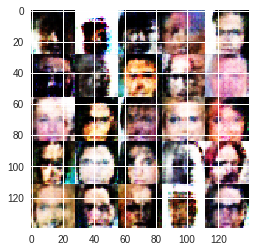

Epoch 3/20... iteration: 3800... Discriminator Loss: 1.3164... Generator Loss: 0.9662
Epoch 3/20... iteration: 3850... Discriminator Loss: 1.3202... Generator Loss: 0.9489
Epoch 3/20... iteration: 3900... Discriminator Loss: 1.3332... Generator Loss: 0.9573
Epoch 3/20... iteration: 3950... Discriminator Loss: 1.3311... Generator Loss: 0.9624
Epoch 3/20... iteration: 4000... Discriminator Loss: 1.3267... Generator Loss: 0.9631


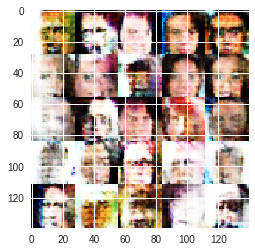

Epoch 3/20... iteration: 4050... Discriminator Loss: 1.3378... Generator Loss: 0.9664
Epoch 3/20... iteration: 4100... Discriminator Loss: 1.3403... Generator Loss: 0.9625
Epoch 3/20... iteration: 4150... Discriminator Loss: 1.3221... Generator Loss: 0.9776
Epoch 3/20... iteration: 4200... Discriminator Loss: 1.3232... Generator Loss: 0.9678
Epoch 3/20... iteration: 4250... Discriminator Loss: 1.3344... Generator Loss: 0.9636


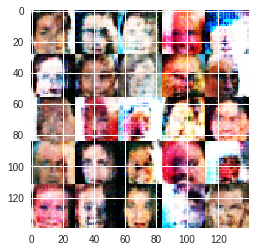

Epoch 3/20... iteration: 4300... Discriminator Loss: 1.3157... Generator Loss: 0.9813
Epoch 3/20... iteration: 4350... Discriminator Loss: 1.3257... Generator Loss: 0.9704
Epoch 3/20... iteration: 4400... Discriminator Loss: 1.3379... Generator Loss: 0.9679
Epoch 3/20... iteration: 4450... Discriminator Loss: 1.3302... Generator Loss: 0.9882
Epoch 3/20... iteration: 4500... Discriminator Loss: 1.3277... Generator Loss: 0.9741


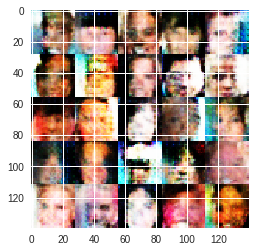

Epoch 3/20... iteration: 4550... Discriminator Loss: 1.3222... Generator Loss: 0.9794
Epoch 3/20... iteration: 4600... Discriminator Loss: 1.3254... Generator Loss: 0.9743
Epoch 3/20... iteration: 4650... Discriminator Loss: 1.3352... Generator Loss: 0.9580
Epoch 3/20... iteration: 4700... Discriminator Loss: 1.3180... Generator Loss: 0.9792
Epoch 4/20... iteration: 4750... Discriminator Loss: 1.3236... Generator Loss: 0.9781


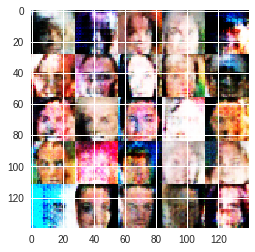

Epoch 4/20... iteration: 4800... Discriminator Loss: 1.3213... Generator Loss: 0.9795
Epoch 4/20... iteration: 4850... Discriminator Loss: 1.3313... Generator Loss: 0.9740
Epoch 4/20... iteration: 4900... Discriminator Loss: 1.3254... Generator Loss: 0.9770
Epoch 4/20... iteration: 4950... Discriminator Loss: 1.3332... Generator Loss: 0.9676
Epoch 4/20... iteration: 5000... Discriminator Loss: 1.3264... Generator Loss: 0.9731


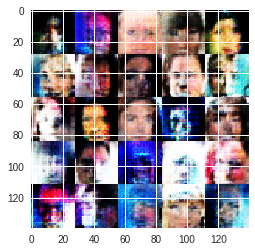

Epoch 4/20... iteration: 5050... Discriminator Loss: 1.3320... Generator Loss: 0.9651
Epoch 4/20... iteration: 5100... Discriminator Loss: 1.3332... Generator Loss: 0.9697
Epoch 4/20... iteration: 5150... Discriminator Loss: 1.3225... Generator Loss: 0.9747
Epoch 4/20... iteration: 5200... Discriminator Loss: 1.3204... Generator Loss: 0.9675
Epoch 4/20... iteration: 5250... Discriminator Loss: 1.3206... Generator Loss: 0.9687


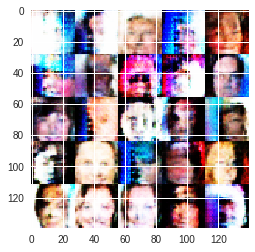

Epoch 4/20... iteration: 5300... Discriminator Loss: 1.3246... Generator Loss: 0.9778
Epoch 4/20... iteration: 5350... Discriminator Loss: 1.3345... Generator Loss: 0.9723
Epoch 4/20... iteration: 5400... Discriminator Loss: 1.3222... Generator Loss: 0.9803
Epoch 4/20... iteration: 5450... Discriminator Loss: 1.3301... Generator Loss: 0.9665
Epoch 4/20... iteration: 5500... Discriminator Loss: 1.3295... Generator Loss: 0.9629


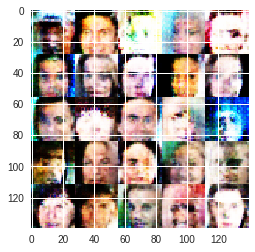

Epoch 4/20... iteration: 5550... Discriminator Loss: 1.3236... Generator Loss: 0.9709
Epoch 4/20... iteration: 5600... Discriminator Loss: 1.3226... Generator Loss: 0.9586
Epoch 4/20... iteration: 5650... Discriminator Loss: 1.3326... Generator Loss: 0.9776
Epoch 4/20... iteration: 5700... Discriminator Loss: 1.3351... Generator Loss: 0.9814
Epoch 4/20... iteration: 5750... Discriminator Loss: 1.3276... Generator Loss: 0.9747


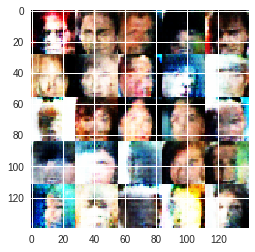

Epoch 4/20... iteration: 5800... Discriminator Loss: 1.3337... Generator Loss: 0.9710
Epoch 4/20... iteration: 5850... Discriminator Loss: 1.3244... Generator Loss: 0.9713
Epoch 4/20... iteration: 5900... Discriminator Loss: 1.3201... Generator Loss: 0.9714
Epoch 4/20... iteration: 5950... Discriminator Loss: 1.3271... Generator Loss: 0.9779
Epoch 4/20... iteration: 6000... Discriminator Loss: 1.3257... Generator Loss: 0.9631


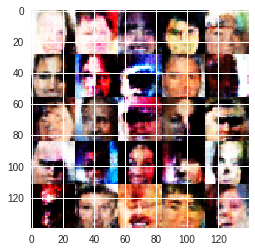

Epoch 4/20... iteration: 6050... Discriminator Loss: 1.3238... Generator Loss: 0.9688
Epoch 4/20... iteration: 6100... Discriminator Loss: 1.3297... Generator Loss: 0.9682
Epoch 4/20... iteration: 6150... Discriminator Loss: 1.3200... Generator Loss: 0.9729
Epoch 4/20... iteration: 6200... Discriminator Loss: 1.3155... Generator Loss: 0.9786
Epoch 4/20... iteration: 6250... Discriminator Loss: 1.3347... Generator Loss: 0.9631


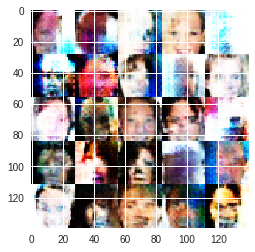

Epoch 4/20... iteration: 6300... Discriminator Loss: 1.3184... Generator Loss: 0.9756
Epoch 5/20... iteration: 6350... Discriminator Loss: 1.3355... Generator Loss: 0.9614
Epoch 5/20... iteration: 6400... Discriminator Loss: 1.3237... Generator Loss: 0.9663
Epoch 5/20... iteration: 6450... Discriminator Loss: 1.3364... Generator Loss: 0.9709
Epoch 5/20... iteration: 6500... Discriminator Loss: 1.3422... Generator Loss: 0.9618


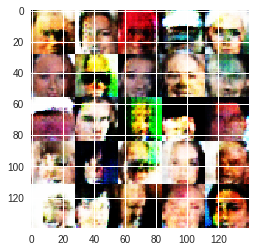

Epoch 5/20... iteration: 6550... Discriminator Loss: 1.3307... Generator Loss: 0.9706
Epoch 5/20... iteration: 6600... Discriminator Loss: 1.3308... Generator Loss: 0.9689
Epoch 5/20... iteration: 6650... Discriminator Loss: 1.3306... Generator Loss: 0.9697
Epoch 5/20... iteration: 6700... Discriminator Loss: 1.3299... Generator Loss: 0.9752
Epoch 5/20... iteration: 6750... Discriminator Loss: 1.3239... Generator Loss: 0.9732


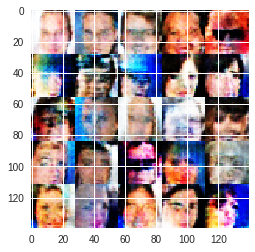

Epoch 5/20... iteration: 6800... Discriminator Loss: 1.3298... Generator Loss: 0.9704
Epoch 5/20... iteration: 6850... Discriminator Loss: 1.3275... Generator Loss: 0.9719
Epoch 5/20... iteration: 6900... Discriminator Loss: 1.3392... Generator Loss: 0.9621
Epoch 5/20... iteration: 6950... Discriminator Loss: 1.3327... Generator Loss: 0.9686
Epoch 5/20... iteration: 7000... Discriminator Loss: 1.3317... Generator Loss: 0.9707


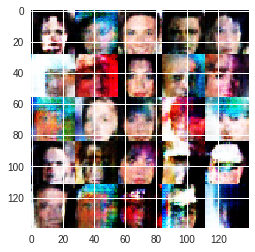

Epoch 5/20... iteration: 7050... Discriminator Loss: 1.3320... Generator Loss: 0.9679
Epoch 5/20... iteration: 7100... Discriminator Loss: 1.3206... Generator Loss: 0.9816
Epoch 5/20... iteration: 7150... Discriminator Loss: 1.3290... Generator Loss: 0.9772
Epoch 5/20... iteration: 7200... Discriminator Loss: 1.3337... Generator Loss: 0.9677
Epoch 5/20... iteration: 7250... Discriminator Loss: 1.3238... Generator Loss: 0.9765


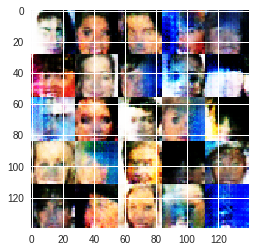

Epoch 5/20... iteration: 7300... Discriminator Loss: 1.3215... Generator Loss: 0.9756
Epoch 5/20... iteration: 7350... Discriminator Loss: 1.3228... Generator Loss: 0.9793
Epoch 5/20... iteration: 7400... Discriminator Loss: 1.3283... Generator Loss: 0.9685
Epoch 5/20... iteration: 7450... Discriminator Loss: 1.3262... Generator Loss: 0.9626
Epoch 5/20... iteration: 7500... Discriminator Loss: 1.3228... Generator Loss: 0.9742


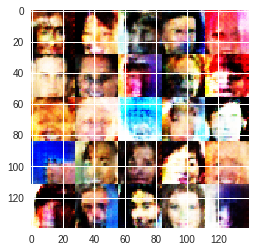

Epoch 5/20... iteration: 7550... Discriminator Loss: 1.3264... Generator Loss: 0.9720
Epoch 5/20... iteration: 7600... Discriminator Loss: 1.3286... Generator Loss: 0.9750
Epoch 5/20... iteration: 7650... Discriminator Loss: 1.3229... Generator Loss: 0.9751
Epoch 5/20... iteration: 7700... Discriminator Loss: 1.3215... Generator Loss: 0.9759
Epoch 5/20... iteration: 7750... Discriminator Loss: 1.3205... Generator Loss: 0.9796


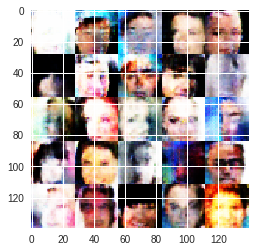

Epoch 5/20... iteration: 7800... Discriminator Loss: 1.3281... Generator Loss: 0.9795
Epoch 5/20... iteration: 7850... Discriminator Loss: 1.3281... Generator Loss: 0.9727
Epoch 5/20... iteration: 7900... Discriminator Loss: 1.3267... Generator Loss: 0.9778
Epoch 6/20... iteration: 7950... Discriminator Loss: 1.3292... Generator Loss: 0.9674
Epoch 6/20... iteration: 8000... Discriminator Loss: 1.3298... Generator Loss: 0.9729


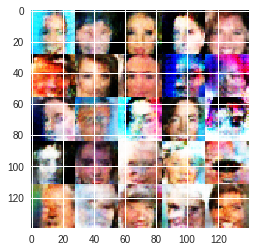

Epoch 6/20... iteration: 8050... Discriminator Loss: 1.3317... Generator Loss: 0.9710
Epoch 6/20... iteration: 8100... Discriminator Loss: 1.3303... Generator Loss: 0.9721
Epoch 6/20... iteration: 8150... Discriminator Loss: 1.3276... Generator Loss: 0.9737
Epoch 6/20... iteration: 8200... Discriminator Loss: 1.3239... Generator Loss: 0.9731
Epoch 6/20... iteration: 8250... Discriminator Loss: 1.3222... Generator Loss: 0.9828


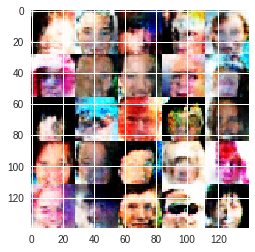

Epoch 6/20... iteration: 8300... Discriminator Loss: 1.3269... Generator Loss: 0.9747
Epoch 6/20... iteration: 8350... Discriminator Loss: 1.3329... Generator Loss: 0.9667
Epoch 6/20... iteration: 8400... Discriminator Loss: 1.3272... Generator Loss: 0.9689
Epoch 6/20... iteration: 8450... Discriminator Loss: 1.3324... Generator Loss: 0.9751
Epoch 6/20... iteration: 8500... Discriminator Loss: 1.3283... Generator Loss: 0.9579


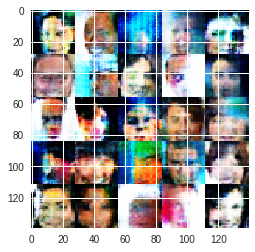

Epoch 6/20... iteration: 8550... Discriminator Loss: 1.3420... Generator Loss: 0.9553
Epoch 6/20... iteration: 8600... Discriminator Loss: 1.3281... Generator Loss: 0.9701
Epoch 6/20... iteration: 8650... Discriminator Loss: 1.3304... Generator Loss: 0.9637
Epoch 6/20... iteration: 8700... Discriminator Loss: 1.3523... Generator Loss: 0.9408
Epoch 6/20... iteration: 8750... Discriminator Loss: 1.3274... Generator Loss: 0.9716


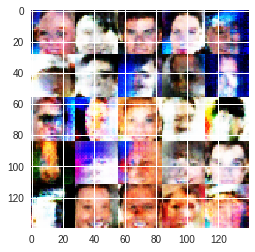

Epoch 6/20... iteration: 8800... Discriminator Loss: 1.3297... Generator Loss: 0.9678
Epoch 6/20... iteration: 8850... Discriminator Loss: 1.3322... Generator Loss: 0.9684
Epoch 6/20... iteration: 8900... Discriminator Loss: 1.3304... Generator Loss: 0.9781
Epoch 6/20... iteration: 8950... Discriminator Loss: 1.3237... Generator Loss: 0.9817
Epoch 6/20... iteration: 9000... Discriminator Loss: 1.3298... Generator Loss: 0.9764


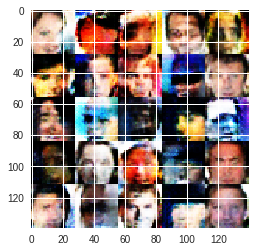

Epoch 6/20... iteration: 9050... Discriminator Loss: 1.3330... Generator Loss: 0.9719
Epoch 6/20... iteration: 9100... Discriminator Loss: 1.3295... Generator Loss: 0.9728
Epoch 6/20... iteration: 9150... Discriminator Loss: 1.3267... Generator Loss: 0.9756
Epoch 6/20... iteration: 9200... Discriminator Loss: 1.3198... Generator Loss: 0.9780
Epoch 6/20... iteration: 9250... Discriminator Loss: 1.3151... Generator Loss: 0.9851


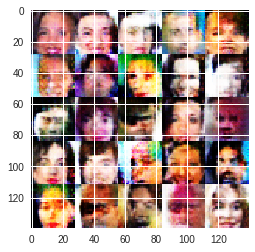

Epoch 6/20... iteration: 9300... Discriminator Loss: 1.3218... Generator Loss: 0.9818
Epoch 6/20... iteration: 9350... Discriminator Loss: 1.3302... Generator Loss: 0.9653


KeyboardInterrupt: ignored

In [18]:
batch_size = 128
z_dim = 120
learning_rate = 0.0005
beta1 = 0.55

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 20

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。